Epoch 1/5
1000/1000 [==============================] - 2s 2ms/step - loss: 0.0648 - accuracy: 0.9762 - val_loss: 0.0205 - val_accuracy: 0.9952
Epoch 2/5
1000/1000 [==============================] - 1s 1ms/step - loss: 0.0138 - accuracy: 0.9970 - val_loss: 0.0164 - val_accuracy: 0.9954
Epoch 3/5
1000/1000 [==============================] - 1s 1ms/step - loss: 0.0103 - accuracy: 0.9981 - val_loss: 0.0160 - val_accuracy: 0.9944
Epoch 4/5
1000/1000 [==============================] - 1s 1ms/step - loss: 0.0092 - accuracy: 0.9983 - val_loss: 0.0173 - val_accuracy: 0.9952
Epoch 5/5
250/250 [==============================] - 0s 439us/step
Epoch 1/5
1000/1000 [==============================] - 3s 3ms/step - loss: 0.0750 - accuracy: 0.9782 - val_loss: 0.0521 - val_accuracy: 0.9883
Epoch 2/5
1000/1000 [==============================] - 3s 3ms/step - loss: 0.0291 - accuracy: 0.9934 - val_loss: 0.0311 - val_accuracy: 0.9918
Epoch 3/5
1000/1000 [==============================] - 3s 3ms/step - loss: 

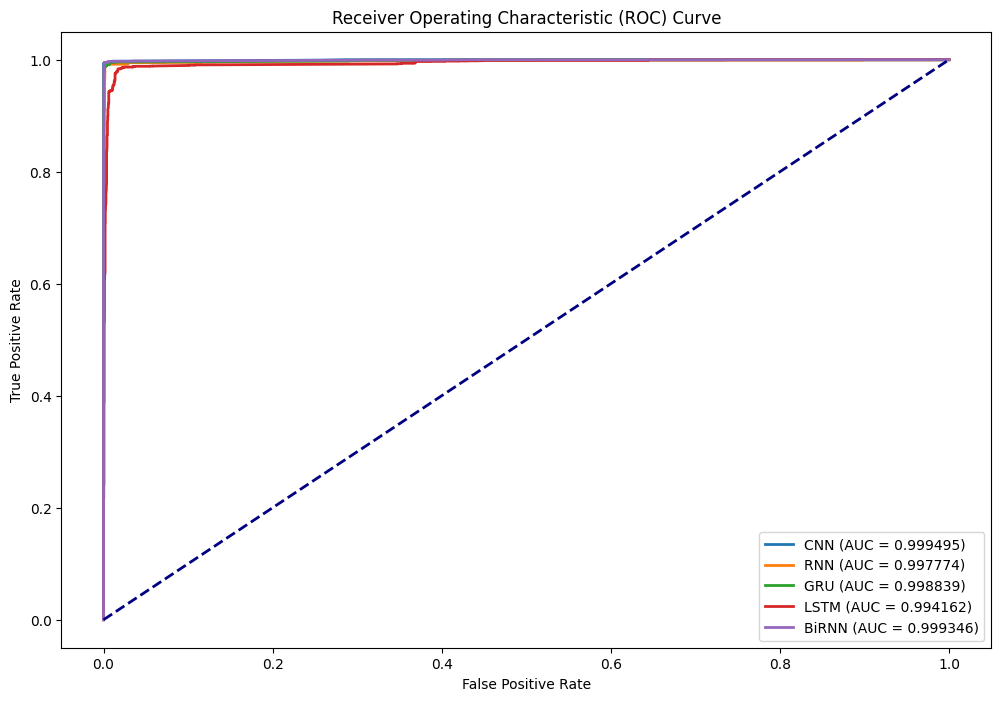

   Model  Accuracy  Precision    Recall  F1-Score
0    CNN  0.995625   0.996585  0.994886  0.995734
1    RNN  0.989000   0.998511  0.980029  0.989184
2    GRU  0.992375   0.993895  0.991232  0.992562
3   LSTM  0.976375   0.967088  0.987579  0.977226
4  BiRNN  0.996125   0.997315  0.995129  0.996221


In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, SimpleRNN, GRU, LSTM, Dense, Bidirectional

# Carrega les dades des del fitxer CSV
data = pd.read_csv('data/DS-2023-000/proxy-sql-dataset.csv', delimiter=";")

# Convertim les etiquetes de text a números (0 o 1)
label_encoder = LabelEncoder()
data['malignant'] = label_encoder.fit_transform(data['malignant'])

# Separem les dades en conjunts d'entrenament i prova
X_train, X_test, y_train, y_test = train_test_split(data['query'], data['malignant'], test_size=0.2, random_state=42)

# Tokenització i padding del text
tokenizer = Tokenizer(num_words=5000, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

X_train_padded = pad_sequences(X_train_sequences, maxlen=50, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_sequences, maxlen=50, padding='post', truncating='post')

# Inicialitza una llista per emmagatzemar els models i els noms
models = []
model_names = ['CNN', 'RNN', 'GRU', 'LSTM', 'BiRNN']

# Crea una figura per a les corbes ROC
plt.figure(figsize=(12, 8))

# Inicialitza un diccionari per emmagatzemar les mètriques
metrics_dict = {'Model': [], 'Accuracy': [], 'Precision': [], 'Recall': [], 'F1-Score': []}

# Construeix i entrena els models
for name in model_names:
    if name == 'CNN':
        model = Sequential([
            Embedding(input_dim=5000, output_dim=16, input_length=50),
            Conv1D(128, 5, activation='relu'),
            GlobalMaxPooling1D(),
            Dense(64, activation='relu'),
            Dense(1, activation='sigmoid')
        ])
    elif name == 'RNN':
        model = Sequential([
            Embedding(input_dim=5000, output_dim=16, input_length=50),
            SimpleRNN(64),
            Dense(1, activation='sigmoid')
        ])
    elif name == 'GRU':
        model = Sequential([
            Embedding(input_dim=5000, output_dim=16, input_length=50),
            GRU(64),
            Dense(1, activation='sigmoid')
        ])
    elif name == 'LSTM':
        model = Sequential([
            Embedding(input_dim=5000, output_dim=16, input_length=50),
            LSTM(64),
            Dense(1, activation='sigmoid')
        ])
    elif name == 'BiRNN':
        model = Sequential([
            Embedding(input_dim=5000, output_dim=16, input_length=50),
            Bidirectional(SimpleRNN(64)),
            Dense(1, activation='sigmoid')
        ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Entrenament del model
    model.fit(X_train_padded, y_train, epochs=5, validation_data=(X_test_padded, y_test))

    models.append(model)

    # Prediccions del model
    y_pred = model.predict(X_test_padded)
    y_pred_binary = (y_pred > 0.5).astype(int)

    # Càlcul de mètriques
    accuracy = accuracy_score(y_test, y_pred_binary)
    classification_rep = classification_report(y_test, y_pred_binary, output_dict=True)

    # Emplenar el diccionari de mètriques
    metrics_dict['Model'].append(name)
    metrics_dict['Accuracy'].append(accuracy)
    metrics_dict['Precision'].append(classification_rep['1']['precision'])
    metrics_dict['Recall'].append(classification_rep['1']['recall'])
    metrics_dict['F1-Score'].append(classification_rep['1']['f1-score'])

    # Calcula la corba ROC
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)

    # Dibuixa la corba ROC
    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.6f})')

# Dibuixa la línia diagonal
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Afegeix etiquetes i llegenda
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

# Mostra la figura
plt.show()

# Mostra la taula comparativa de mètriques
metrics_df = pd.DataFrame(metrics_dict)
print(metrics_df)

In [2]:
# Convertir el DataFrame a una cadena en format LaTeX
latex_table = metrics_df.to_latex(index=False, float_format="%.6f")

# Imprimir la cadena LaTeX
print(latex_table)

\begin{tabular}{lrrrr}
\toprule
Model &  Accuracy &  Precision &   Recall &  F1-Score \\
\midrule
  CNN &  0.996125 &   0.996830 & 0.995616 &  0.996223 \\
  RNN &  0.995000 &   0.995370 & 0.994886 &  0.995128 \\
  GRU &  0.991875 &   0.994857 & 0.989284 &  0.992063 \\
 LSTM &  0.939875 &   0.976597 & 0.904530 &  0.939183 \\
BiRNN &  0.994125 &   0.993435 & 0.995129 &  0.994282 \\
\bottomrule
\end{tabular}



/var/folders/pr/64sz3y6x4nx3lv0kdhq943jm0000gn/T/ipykernel_44016/4036293263.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_table = metrics_df.to_latex(index=False, float_format="%.6f")
